In [16]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset('./KURO.nc')

ds


<xarray.Dataset> Size: 12GB
Dimensions:    (time: 11322, latitude: 256, longitude: 256)
Coordinates:
  * latitude   (latitude) float32 1kB 10.06 10.19 10.31 ... 41.69 41.81 41.94
  * longitude  (longitude) float32 1kB 123.1 123.2 123.3 ... 154.7 154.8 154.9
  * time       (time) datetime64[ns] 91kB 1993-01-01 1993-01-02 ... 2023-12-31
Data variables:
    vgos       (time, latitude, longitude) float64 6GB ...
    ugos       (time, latitude, longitude) float64 6GB ...
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-12-31T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-12-30T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    copernicusmarine_version:        1.3.3

In [23]:
import xarray as xr

ds = xr.open_dataset('./KURO.nc')

time_index = ds.time.to_index()

target_date = '2021-01-01'
index = time_index.get_loc(target_date)

print(f"idex：{index}")

idex：10227


In [17]:
import xarray as xr
import numpy as np
import h5py

ds = xr.open_dataset('./KURO.nc')

years = np.unique(ds.time.dt.year.values)

for year in years:
    ds_year = ds.sel(time=ds.time.dt.year == year)
    
    ugos_data = ds_year.ugos.values  # (days, 256, 256)
    ugos_data = np.flip(ugos_data, 1)
    vgos_data = ds_year.vgos.values
    vgos_data = np.flip(vgos_data, 1)
    combined = np.stack([ugos_data, vgos_data], axis=1)  #(days, 2, 256, 256)
    
    with h5py.File(f'./data_h5/{year}.h5', 'w') as f:
        f.create_dataset('fields', data=combined)
    
    print(f'Have saved {year}.h5, data dimension: {combined.shape}')

已保存 1993.h5，数据维度：(365, 2, 256, 256)
已保存 1994.h5，数据维度：(365, 2, 256, 256)
已保存 1995.h5，数据维度：(365, 2, 256, 256)
已保存 1996.h5，数据维度：(366, 2, 256, 256)
已保存 1997.h5，数据维度：(365, 2, 256, 256)
已保存 1998.h5，数据维度：(365, 2, 256, 256)
已保存 1999.h5，数据维度：(365, 2, 256, 256)
已保存 2000.h5，数据维度：(366, 2, 256, 256)
已保存 2001.h5，数据维度：(365, 2, 256, 256)
已保存 2002.h5，数据维度：(365, 2, 256, 256)
已保存 2003.h5，数据维度：(365, 2, 256, 256)
已保存 2004.h5，数据维度：(366, 2, 256, 256)
已保存 2005.h5，数据维度：(365, 2, 256, 256)
已保存 2006.h5，数据维度：(365, 2, 256, 256)
已保存 2007.h5，数据维度：(365, 2, 256, 256)
已保存 2008.h5，数据维度：(366, 2, 256, 256)
已保存 2009.h5，数据维度：(365, 2, 256, 256)
已保存 2010.h5，数据维度：(365, 2, 256, 256)
已保存 2011.h5，数据维度：(365, 2, 256, 256)
已保存 2012.h5，数据维度：(366, 2, 256, 256)
已保存 2013.h5，数据维度：(365, 2, 256, 256)
已保存 2014.h5，数据维度：(365, 2, 256, 256)
已保存 2015.h5，数据维度：(365, 2, 256, 256)
已保存 2016.h5，数据维度：(366, 2, 256, 256)
已保存 2017.h5，数据维度：(365, 2, 256, 256)
已保存 2018.h5，数据维度：(365, 2, 256, 256)
已保存 2019.h5，数据维度：(365, 2, 256, 256)
已保存 2020.h5，数据维度：(366, 2, 25

In [18]:
import os
import numpy as np
import h5py
import time 

#calculate climate mean
def compute_climate_mean(data_dir, start_year=1993, end_year=2019, output_file='./climate_mean.npy'):
    
    selected_vars = range(0, 2)
    total_vars = 2
    total_days = 365
    spatial_dims = (256, 256)
    
    sum_data = None
    valid_years = 0  
    
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(data_dir, f'{year}.h5')
        
        if not os.path.exists(file_path):
            print(f"警告：文件 {file_path} 不存在，跳过该年份。")
            continue
        
        start_time = time.time() 
        
        with h5py.File(file_path, 'r') as ds:
            data = ds['fields'][:total_days]  #  (365, 97, 121, 240)
            
            selected_data = data[:, selected_vars, :, :]  # 形状为 (365, 46, 121, 240)
            
            if sum_data is None:
                sum_data = np.zeros_like(selected_data, dtype=np.float64)
            
            sum_data += selected_data
            valid_years += 1
        
        end_time = time.time()  # 
        elapsed_time = end_time - start_time
        print(f"已处理年份 {year}，耗时 {elapsed_time:.2f} 秒。")
    
    if valid_years == 0:
        raise ValueError("未找到任何有效的数据文件。请检查数据目录和年份范围。")
    
    print(f"总共处理了 {valid_years} 个年份的数据。")
    
    mean_data = sum_data / valid_years  #  (365, 46, 121, 240)
    
    output_array = np.zeros((total_days, total_vars, spatial_dims[0], spatial_dims[1]), dtype=np.float32)
    
    for idx, var_idx in enumerate(selected_vars):
        output_array[:, var_idx, :, :] = mean_data[:, idx, :, :]
    
    np.save(output_file, output_array)
    print(f"气候平均态已保存到 {output_file}")


data_directory = './data_h5'
output_filename = './climate_mean.npy'
compute_climate_mean(data_dir=data_directory, start_year=1993, end_year=2019, output_file=output_filename)


已处理年份 1993，耗时 2.33 秒。
已处理年份 1994，耗时 1.32 秒。
已处理年份 1995，耗时 1.18 秒。
已处理年份 1996，耗时 1.10 秒。
已处理年份 1997，耗时 1.07 秒。
已处理年份 1998，耗时 1.65 秒。
已处理年份 1999，耗时 3.14 秒。
已处理年份 2000，耗时 0.78 秒。
已处理年份 2001，耗时 0.79 秒。
已处理年份 2002，耗时 0.69 秒。
已处理年份 2003，耗时 0.88 秒。
已处理年份 2004，耗时 0.81 秒。
已处理年份 2005，耗时 0.79 秒。
已处理年份 2006，耗时 0.80 秒。
已处理年份 2007，耗时 0.75 秒。
已处理年份 2008，耗时 0.69 秒。
已处理年份 2009，耗时 0.71 秒。
已处理年份 2010，耗时 0.78 秒。
已处理年份 2011，耗时 0.72 秒。
已处理年份 2012，耗时 0.78 秒。
已处理年份 2013，耗时 0.89 秒。
已处理年份 2014，耗时 0.91 秒。
已处理年份 2015，耗时 0.81 秒。
已处理年份 2016，耗时 0.74 秒。
已处理年份 2017，耗时 0.80 秒。
已处理年份 2018，耗时 0.78 秒。
已处理年份 2019，耗时 0.80 秒。
总共处理了 27 个年份的数据。
气候平均态已保存到 ./climate_mean.npy


(365, 2, 256, 256)


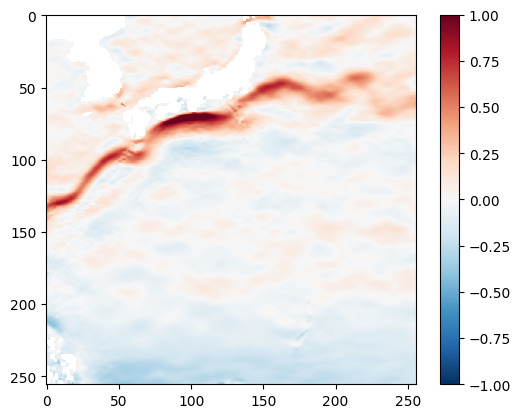

In [21]:
import xarray as xr
import matplotlib.pyplot as plt

ds = np.load('./climate_mean.npy')
print(ds.shape)

data = ds[200, 0, :, :]

plt.imshow(data, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [9]:
import h5py

ds = h5py.File('./forecast_20210215.h5')
print(ds.keys())
prediction = ds['prediction'][0, 100, 0, :, :]
print(np.mean(prediction))

<KeysViewHDF5 ['initial', 'initial_dates', 'label', 'label_dates', 'prediction']>
0.0073994473


In [3]:
import os
import h5py
import numpy as np

def merge_label_prediction(output_file='forecast_merged.h5'):
    # 1) 找出当前目录下所有 forecast_*.h5 文件，并按文件名排序
    file_list = sorted([
        f for f in os.listdir('.')
        if f.startswith('forecast_') and f.endswith('.h5')
    ])

    if len(file_list) == 0:
        print("未找到任何 forecast_*.h5 文件！")
        return

    all_label = []
    all_prediction = []

    # 2) 逐个读取并收集 label、prediction
    for fname in file_list:
        print(f"Merging {fname}")
        with h5py.File(fname, 'r') as f:
            all_label.append(f['label'][:])         # shape 比如 (1, 120, 2, 128, 128)
            all_prediction.append(f['prediction'][:])

    # 3) 沿着第0维拼接 (把原先每个文件中的前置“1”给堆叠起来)
    merged_label = np.concatenate(all_label, axis=0)
    merged_prediction = np.concatenate(all_prediction, axis=0)

    # 4) 写出合并结果到新文件
    with h5py.File(output_file, 'w') as f_out:
        f_out.create_dataset('label', data=merged_label, compression='gzip')
        f_out.create_dataset('prediction', data=merged_prediction, compression='gzip')

    print("合并完成！")
    print("merged_label shape:", merged_label.shape)
    print("merged_prediction shape:", merged_prediction.shape)

if __name__ == "__main__":
    merge_label_prediction()


Merging forecast_20210101.h5
Merging forecast_20210106.h5
Merging forecast_20210111.h5
Merging forecast_20210116.h5
Merging forecast_20210121.h5
Merging forecast_20210126.h5
Merging forecast_20210131.h5
Merging forecast_20210205.h5
Merging forecast_20210210.h5
Merging forecast_20210215.h5
Merging forecast_20210220.h5
Merging forecast_20210225.h5
Merging forecast_20210302.h5
Merging forecast_20210307.h5
Merging forecast_20210312.h5
Merging forecast_20210317.h5
Merging forecast_20210322.h5
Merging forecast_20210327.h5
Merging forecast_20210401.h5
Merging forecast_20210406.h5
Merging forecast_20210411.h5
Merging forecast_20210416.h5
Merging forecast_20210421.h5
Merging forecast_20210426.h5
Merging forecast_20210501.h5
Merging forecast_20210506.h5
Merging forecast_20210511.h5
Merging forecast_20210516.h5
Merging forecast_20210521.h5
Merging forecast_20210526.h5
Merging forecast_20210531.h5
Merging forecast_20210605.h5
Merging forecast_20210610.h5
Merging forecast_20210615.h5
Merging foreca

In [10]:
import h5py
import numpy as np

ds = h5py.File('./forecast_merged.h5')
print(ds.keys())
prediction = ds['prediction'][9, 100, 0, :, :]
print(np.mean(prediction))

<KeysViewHDF5 ['label', 'prediction']>
0.0073994473


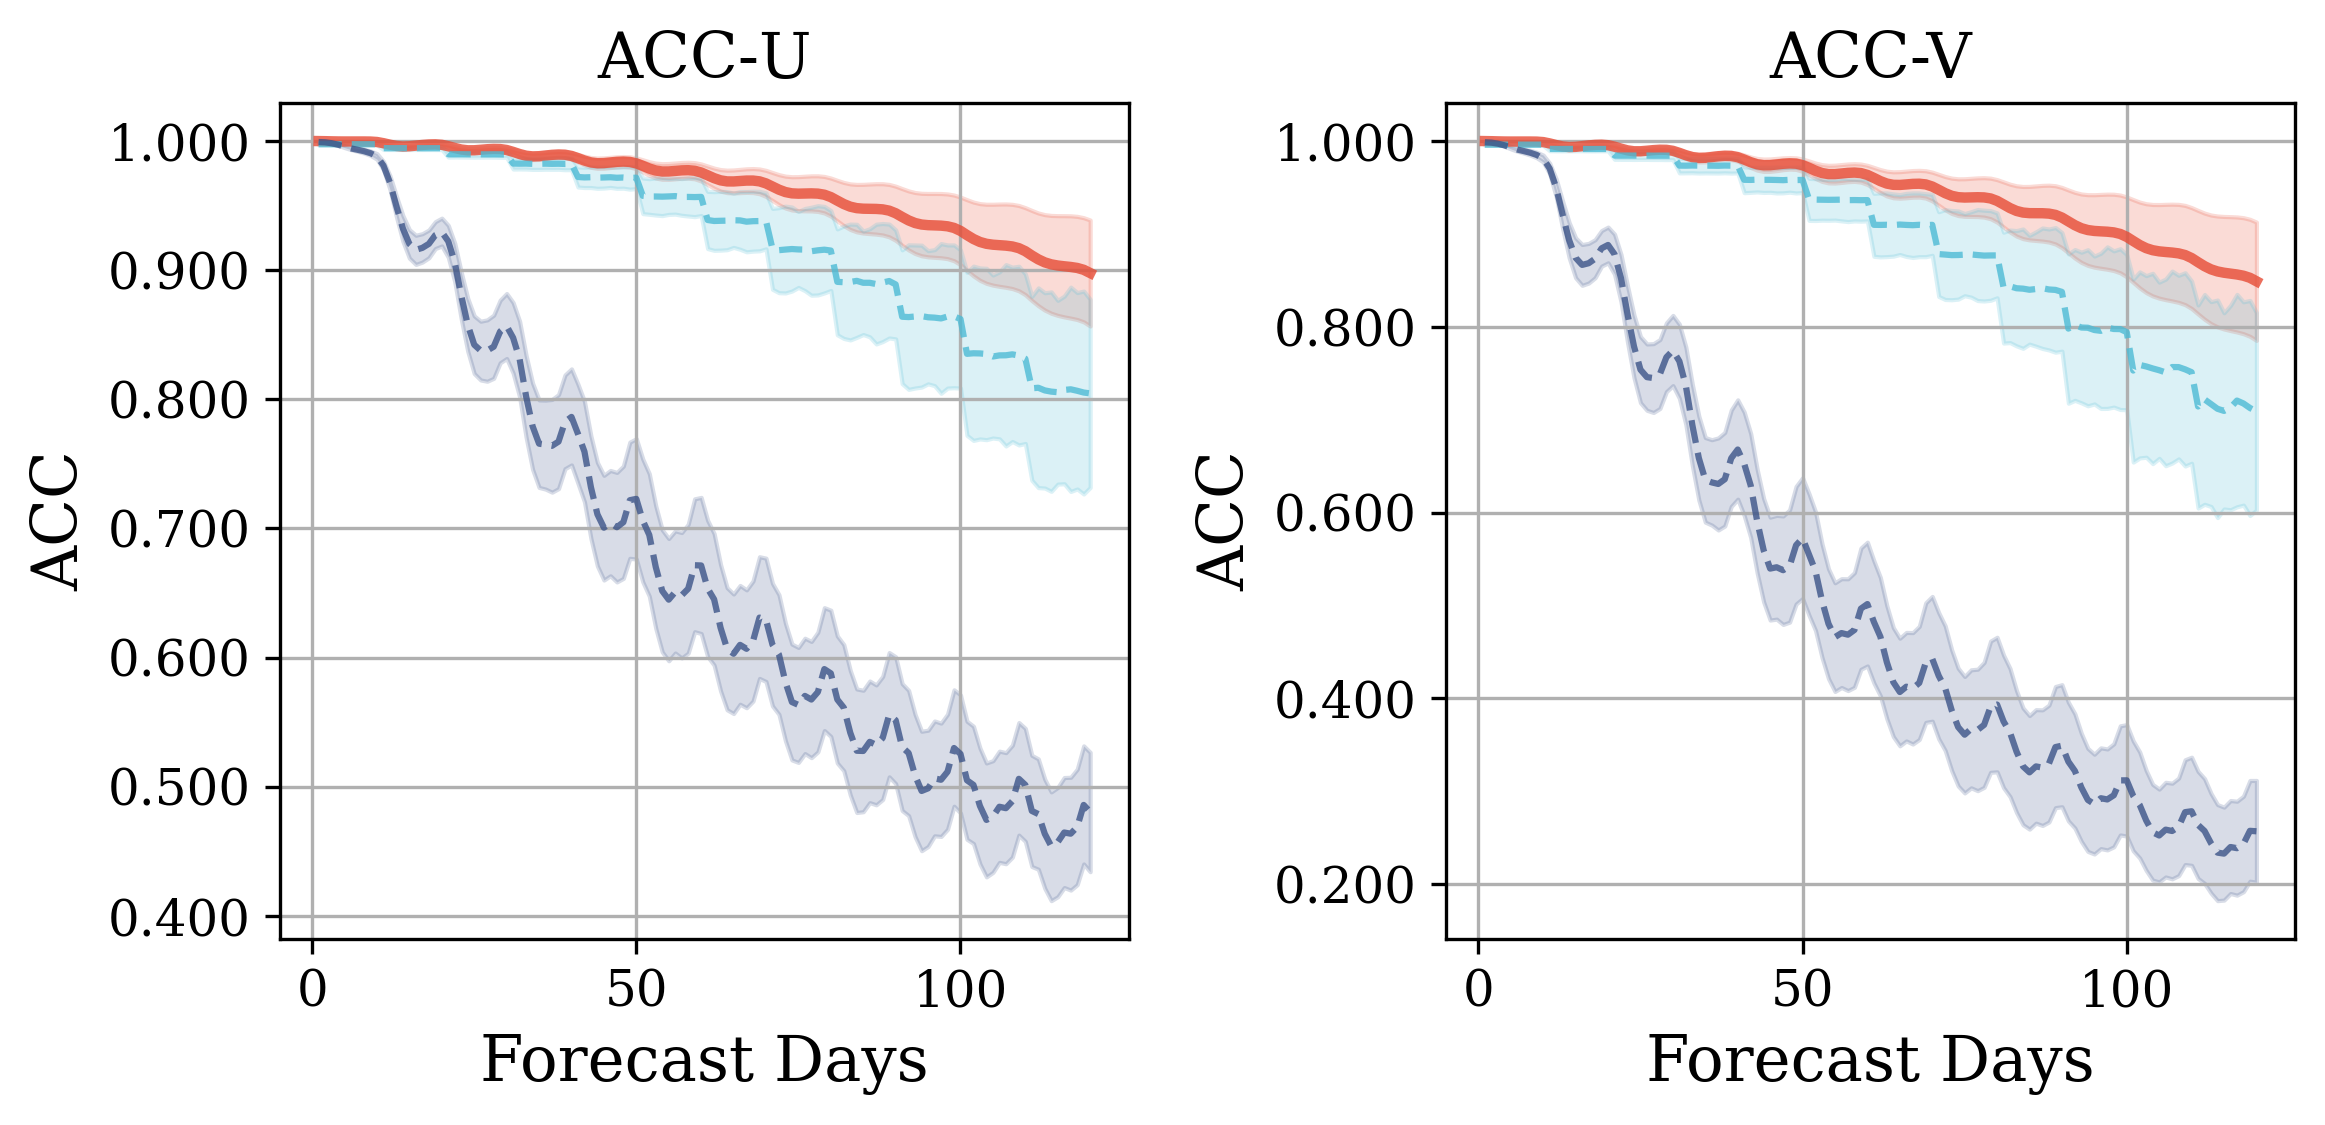

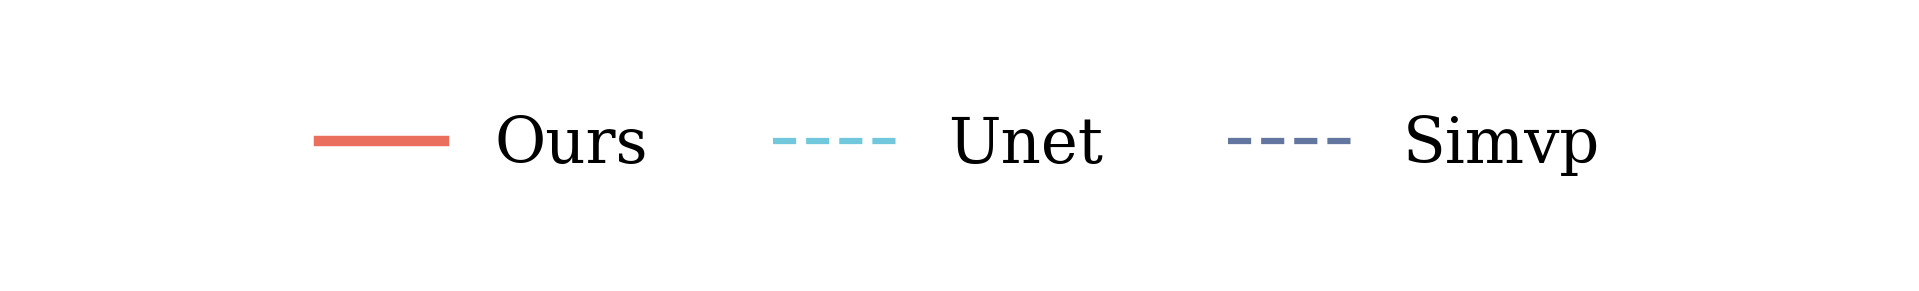

In [4]:
import matplotlib.pyplot as plt
import h5py
import torch
import numpy as np
from matplotlib.ticker import FormatStrFormatter  # 用于格式化 y 轴刻度标签
import matplotlib.lines as mlines  # 用于创建自定义图例

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "DejaVu Serif"
# def lat_np(j, num_lat):
#     return 90. - j * 180. / (num_lat - 1)

def lat_np(j, num_lat):
    return 10. + j * (42. - 10.) / (num_lat - 1)

def latitude_weighting_factor(j, num_lat, s):
    return num_lat * np.cos(np.pi / 180. * lat_np(j, num_lat)) / s  # 使用更精确的 π 值

def weighted_acc(pred, target):
    """
    计算纬向加权的 ACC，并返回适配绘图函数的值。
    """
    num_lat = np.shape(pred)[0]  # 纬度数量
    lat_t = np.arange(0, num_lat)

    # 计算纬度权重
    s = np.sum(np.cos(np.pi / 180. * lat_np(lat_t, num_lat)))
    weight = np.reshape(latitude_weighting_factor(lat_t, num_lat, s), (num_lat, 1))  # 调整为 [lat, 1]

    # 计算加权的 ACC
    numerator = np.nansum(weight * pred * target)
    denominator = np.sqrt(
        np.nansum(weight * pred ** 2) * np.nansum(weight * target ** 2)
    )
    # 防止分母为零
    if denominator == 0:
        return np.nan

    acc = numerator / denominator
    return acc

var_idex = {
    "U": 0, "V": 1
}

# 定义绘图的颜色
color = {
    0: '#E64B35CC',
    1: '#4DBBD5CC',
    2: '#3C5488CC',
    3: '#00A087CC',
    4: '#F39B7FCC',
    5: '#8491B4CC',
    6: '#91D1C2CC',
}

model_index = {'Ours': 0, 'Unet': 1, 'Simvp': 2}


datasets = {
    'Ours': h5py.File('/jizhicfs/easyluwu/ocean_project/NPJ_baselines/Exp_2_Kuroshio/inference_results_open/Kuro_Triton_exp1_128_20250322_forecast_results/forecast_merged.h5'),
    'Unet': h5py.File('/jizhicfs/easyluwu/ocean_project/NPJ_baselines/Exp_2_Kuroshio/inference_results_open/Kuro_Unet_exp_128_20250324_forecast_results/forecast_merged.h5'),
    'Simvp': h5py.File('/jizhicfs/easyluwu/ocean_project/NPJ_baselines/Exp_2_Kuroshio/inference_results_open/Kuro_Simvp_exp_128_20250324_forecast_results/forecast_merged.h5'),
}


ics = 73
var_name = ['U', 'V']  
variables = [var_idex[name] for name in var_name]
titles = ['ACC-U', 'ACC-V']
model_names = ['Ours', 'Unet', 'Simvp']
time_steps_per_day = 1

acc_per_model = {model: {var: {'mean': [], 'std': []} for var in variables} for model in model_names}
ds_climate_mean = np.load('/jizhicfs/easyluwu/ocean_project/NPJ_baselines/Exp_2_Kuroshio/inference_results_open/climate_mean.npy')[:, :, :256:2, :256:2]
for model in model_names:
    ds = datasets[model]  # 获取对应模型的数据集
    for var in variables:
        for day in range(1, 121):  # 从第1天到第10天
            time = day * time_steps_per_day
            acc_day_list = []  # 用于收集每个初始条件的 ACC

            for ic in range(ics):
                # 获取预测和真实值的数据
                climate_mean_idx = 5*ic+time
                if climate_mean_idx < 364:
                    climate_mean = ds_climate_mean[5*ic+time, var, :, :]
                else:
                    climate_mean = ds_climate_mean[5*ic+time-365, var, :, :]
                    
                pre = torch.tensor(ds['prediction'][ic, time-1, var, :, :]).numpy()
                tar = torch.tensor(ds['label'][ic, time-1, var, :, :]).numpy()
                pre = pre - climate_mean
                tar = tar - climate_mean
                

                # 计算 ACC
                acc = weighted_acc(pre, tar)
                acc_day_list.append(acc)

            # 计算该天的平均值和标准差
            acc_mean = np.mean(acc_day_list)
            acc_std = np.std(acc_day_list)

            acc_per_model[model][var]['mean'].append(acc_mean)
            acc_per_model[model][var]['std'].append(acc_std)

days = np.arange(1, 121) 

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300) 

plt.rcParams.update({'font.size': 15})

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[i]  
    for model in model_names:
        idx = model_index[model]
        mean = np.array(acc_per_model[model][var]['mean'])
        std = np.array(acc_per_model[model][var]['std'])

        lw = 2.5 if model == 'Ours' else 1.5
        ls = '-' if model == 'Ours' else '--'

        ax.plot(days, mean, label=model, color=color[idx], linewidth=lw, linestyle=ls)

        ax.fill_between(days, mean - std, mean + std, color=color[idx], alpha=0.2)

    ax.set_xlabel('Forecast Days', fontsize=15)
    ax.set_ylabel('ACC', fontsize=15)
    ax.set_title(title, fontsize=15)
    ax.grid()

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('visual_acc.jpg', dpi=300, bbox_inches='tight')
plt.show()

fig_legend = plt.figure(figsize=(8, 1), dpi=300)
legend_handles = []
for model in model_names:
    idx = model_index[model]
    lw = 2.5 if model == 'Ours' else 1.5
    ls = '-' if model == 'Ours' else '--'
    line = mlines.Line2D([], [], color=color[idx], linewidth=lw, linestyle=ls, label=model)
    legend_handles.append(line)

fig_legend.legend(handles=legend_handles, loc='center', ncol=len(model_names), fontsize=15, frameon=False)
plt.axis('off')
plt.show()